# 1 GAN 

## 1.1 Data
You can find a dataset on the Moodle website (ising data.zip). These are some Monte Carlo samples
of the standard ferromagnetic 2D Ising model on a square lattice of size $40x40$ generated at different
temperatures. For each temperature there are 1001 spin configurations. The factor indicates how
close it is to the critical temperature (e.g. 1 corresponds to $0.1\beta_c$, $\beta_c = 1/(T_c k_B)$). It contains various
numpy arrays so you can load the datasets using numpy.

In [13]:
import numpy as np
import os

data = {}
temps = []
# go through all files in the folder "ising data"
for file in os.listdir("ising_data"):
    t = int(file.split(".")[0].split("_")[1])
    # add the data of each file to the data dictionary
    data[t] = (np.load("ising_data/" + file))
    # add the name of the file to temps
    temps.append(t)
    

print("Shape of the data which was loaded from the folder ising_data: " + str(data[11].shape))
print("Temperatures:")
print(temps)


Shape of the data which was loaded from the folder ising_data: (1001, 40, 40)
Temperatures:
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


## 1.2 GAN Implementation
Build a GAN with a custom training loop (as in sheet 10) that aims at generating Ising samples
below the critical temperature. Analyze the energy and magnetization of both the original dataset
and the generated Ising samples.
Note that in case you do not have a local environment where you can calculate on a GPU, you
can calculate online on collab on a GPU.

In [14]:
# import the libraries
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import GradientTape
from tensorflow.python.data import Dataset
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Activation, Input, Reshape, Flatten, Dropout, GlobalMaxPooling2D, Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
class GAN:
    """
    Class to build and fit a GAN.
    """
    def __init__(self, temp_data, num_classes=10, batch_size=128):
        self.x_train = temp_data
        # the gerated images will have values between 0 and 1 --> rescale the real images
        for i in range(len(self.x_train)): 
              self.x_train[i] = (self.x_train[i]+1)/2

        self.train_dataset = None
        self.generator = None
        self.discriminator = None
        self.batch_size = batch_size
        self.gen_optimizer = Adam(1e-4)
        self.discr_optimizer = Adam(1e-4)

        self.input_shape = self.x_train[0].shape
        self.latent_dim = (128,)
    
    def losses(self):
        """ Define the loss functions for discriminator and generator. """
        def discriminator_loss(real_output, fake_output):
            real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
            fake_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
            total_loss = real_loss + fake_loss
            return total_loss
        def generator_loss(fake_output):
            return BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
        return generator_loss, discriminator_loss    
    

    def build_generator(self):
        """ Build the generator model. """
        model = Sequential(name="Generator")
        # input: shape (100,)
        model.add(Input(shape=self.latent_dim))
        #model.add(Dense(6000))
        #model.add(LeakyReLU(alpha=0.2))
        # add a dense layer with batch size *10* 10 nodes and reshape it to 
        # (batch size, 10, 10)
        model.add(Dense(self.batch_size*100))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((10, 10, self.batch_size)))
        # go from (batch size, 10, 10) to (batch size, 40, 40) which is the desired
        # output shape
        model.add(Conv2DTranspose(self.batch_size, (2, 2), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(self.batch_size, (2, 2), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (10, 10), padding="same", activation="sigmoid"))
        # output: shape (batch size, 40, 40)
        model.add(Reshape(self.input_shape))
        self.generator = model

        self.generator.summary()
        
    def build_discriminator(self):
        """ Build the discriminator model. """
        model = Sequential(name="Discriminator")
        model.add(Input(shape=self.input_shape))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.summary()
        self.discriminator = model
                         
    
    def build_full_GAN(self):
        """ Build the full GAN. """
        self.build_generator()
        self.build_discriminator()


    def fit_data_custom(self, epochs=10):
        """ Fit the data with a custum training loop. """
        # Create batches
        self.build_batches()

        for epoch in range(epochs):
            print("Beginning epoch ", epoch + 1)
            # Go through the images of each batch and create fake images.
            for images in self.train_dataset:
                generated_images = self.execute_training_step(images)
            # output the fake and real images, energy and magnetization of the last batch.
            self.plot_configurations(images, generated_images)
            real_magnetization = self.calculate_magnetization(images)
            fake_magnetization = self.calculate_magnetization(generated_images)
            print("real average magnetization: " + str(real_magnetization) + ", fake average magnetization:" + str(fake_magnetization))
            real_energy = self.calculate_energy(images)
            fake_energy = self.calculate_energy(generated_images)
            print("real average energy: " + str(real_energy) + ", fake average energy:" + str(fake_energy))


    def build_batches(self):
        self.train_dataset = Dataset.from_tensor_slices((self.x_train))
        self.train_dataset = self.train_dataset.shuffle(buffer_size=len(self.x_train))
        self.train_dataset = self.train_dataset.batch(self.batch_size)

    # Remove this to check timing
    @tf.function
    def execute_training_step(self, images):
        # Gneerate the input for the generator: random noise with the right shape.
        noise = tf.random.normal([self.batch_size, self.latent_dim[0]])
        # Get the losses
        generator_loss, discriminator_loss = self.losses()
        with GradientTape() as gen_tape, GradientTape() as disc_tape:
            # Generate the fake images.
            print("generator input shape", noise.shape )
            generated_images = self.generator(noise, training=True)

            # Classify the real and fake images.
            print("discriminator input shape", noise.shape )
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            # Calculate the loss.
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        # Track the gradients of both models.
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discr_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return generated_images


    def plot_configurations(self, real_images, fake_images):
        """ Plots the spin configurations of the ising model. """
        f, axs = plt.subplots(1,2)
        axs[0].imshow(real_images[0], vmin=0, vmax=1)
        axs[1].imshow(fake_images[0], vmin=0, vmax=1)
        axs[0].title.set_text("real image")
        axs[1].title.set_text("fake image")
        f.set_figheight(10)
        f.set_figwidth(10)
        plt.show()

    def calculate_magnetization(self, images):
        """ Calculates the average magnetization of several images. """
        average_magnetization = 0
        for image in images:
            average_magnetization += abs(np.sum(image))
        # divide it by the number of images and the maximal magnetization (40*40)
        average_magnetization = average_magnetization/(len(images)*40*40)
        # the samples have values between 0 and 1 --> rescale the magnetization
        average_magnetization = abs((average_magnetization*2)-1)
        return average_magnetization

    def calculate_energy(self, images):
        """ Calculates the average energy of several images. """
        average_energy = 0
        for image in images:
          # the samples have values between 0 and 1 --> rescale them
            image = (image*2) -1
            e = 0
            for i in range(40):
                for j in range(40):
                    if j < i:
                      e += - image[i,j] * (image[i, (j+1)%40] + image[(i+1)%40, j])
            average_energy += e
        average_energy = average_energy/len(images)
        return average_energy.numpy()
        
            
    



### The GAN
Look at the generator and the discriminator:
- the generator starts with self.latent_dim (here 100) and outputs self.input_dim (here 40x40)
- the discriminator starts with self.self.input_dim (here 40x40) and classifies (dimension 1)

In [16]:
# Take the data at a specific temperature 
temp_data = data[11]
print(data[11].shape)

# Create a GAN instance and build the GAN
gan = GAN(temp_data)
gan.build_full_GAN()

(1001, 40, 40)
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 12800)             1651200   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 12800)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 20, 20, 128)       65664     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 40, 40, 128)       65664     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 40, 40

### Before the training
Without training, the generator produces images like on the left, but the real configurations look like on the right:

(1, 40, 40)


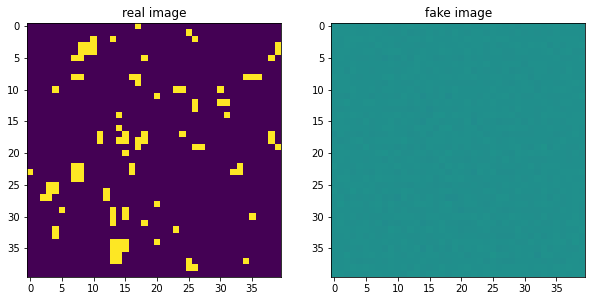

In [17]:
# generate noise as input for the generator, and generate an image
noise = tf.random.normal([1, gan.latent_dim[0]], mean=0.0)
generated_image = gan.generator(noise, training = False)
print(generated_image.shape)
# look at a real and a fake image
gan.plot_configurations(gan.x_train, generated_image)

### Training
Now we train the GAN:

Beginning epoch  1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
generator input shape (128, 128)
discriminator input shape (128, 128)
generator input shape (128, 128)
discriminator input shape (128, 128)
generator input shape (128, 128)
discriminator input shape (128, 128)


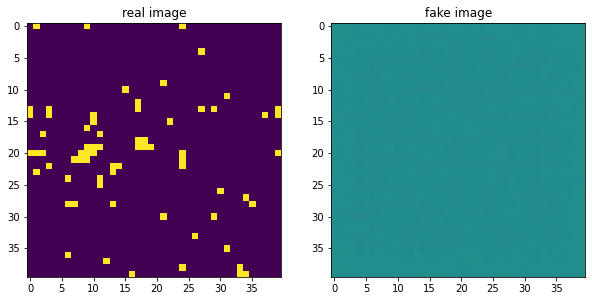

real average magnetization: 0.8894047619047619, fake average magnetization:0.03074521899223326
real average energy: -0.62857145, fake average energy:-1.5397677
Beginning epoch  2


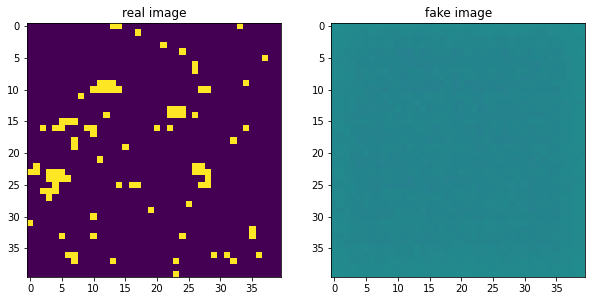

real average magnetization: 0.88225, fake average magnetization:0.08141923129558559
real average energy: 0.60952383, fake average energy:-10.704679
Beginning epoch  3


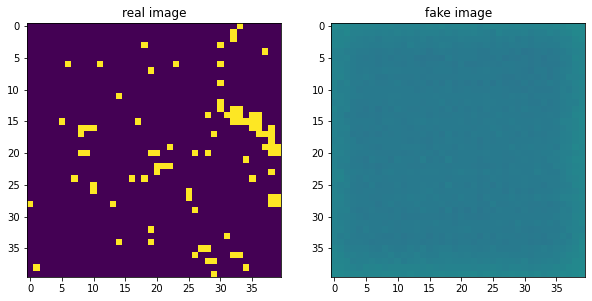

real average magnetization: 0.884, fake average magnetization:0.1633790719509125
real average energy: 0.47619048, fake average energy:-43.04443
Beginning epoch  4


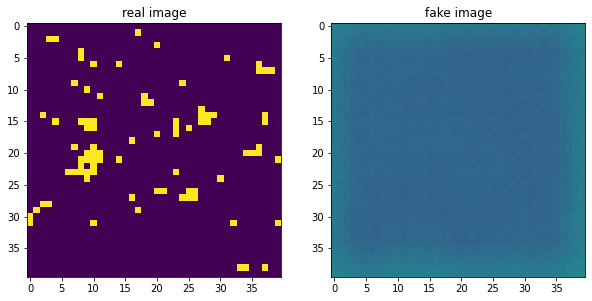

real average magnetization: 0.8912261904761904, fake average magnetization:0.30085606932640074
real average energy: 0.9142857, fake average energy:-145.2381
Beginning epoch  5


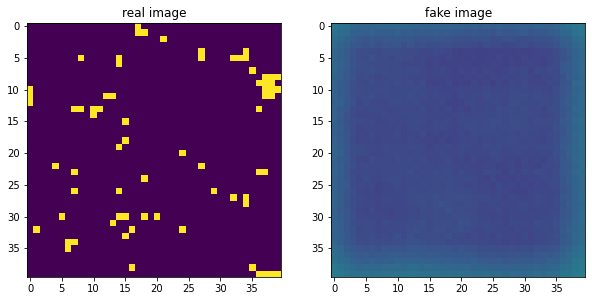

real average magnetization: 0.8821904761904762, fake average magnetization:0.5118132489919662
real average energy: -0.81904763, fake average energy:-418.44287
Beginning epoch  6


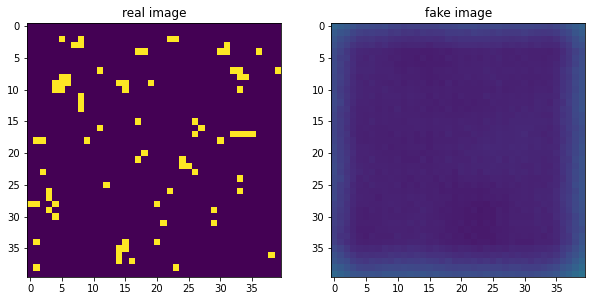

real average magnetization: 0.8859404761904762, fake average magnetization:0.7603184692561626
real average energy: -0.3809524, fake average energy:-911.8972
Beginning epoch  7


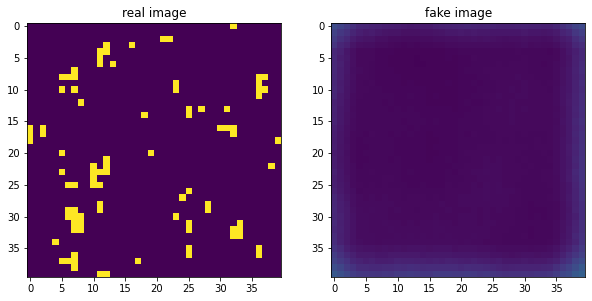

real average magnetization: 0.8861190476190476, fake average magnetization:0.9178333879262209
real average energy: 1.2, fake average energy:-1318.191
Beginning epoch  8


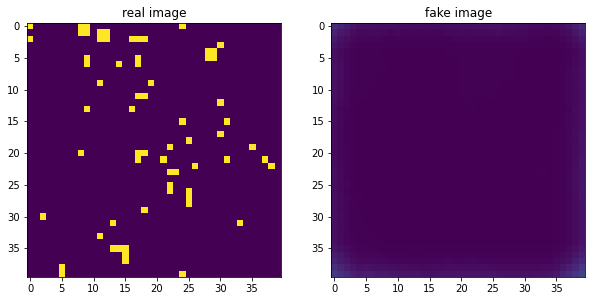

real average magnetization: 0.8850238095238095, fake average magnetization:0.9759293541312217
real average energy: -0.24761905, fake average energy:-1486.0815
Beginning epoch  9


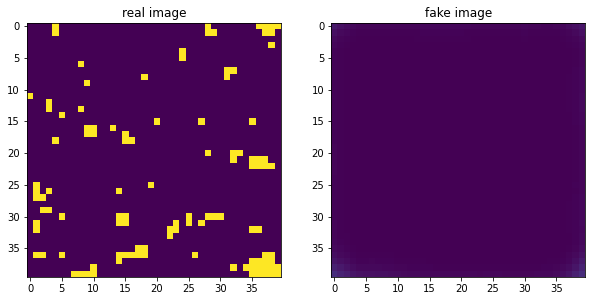

real average magnetization: 0.8873809523809524, fake average magnetization:0.9912453687260858
real average energy: 1.0857143, fake average energy:-1532.6736
Beginning epoch  10


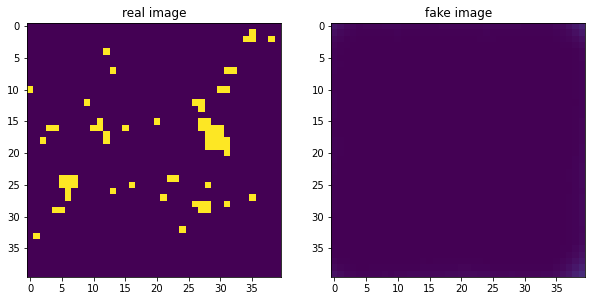

real average magnetization: 0.8892976190476191, fake average magnetization:0.9962662962207105
real average energy: -0.81904763, fake average energy:-1548.5146
Beginning epoch  11


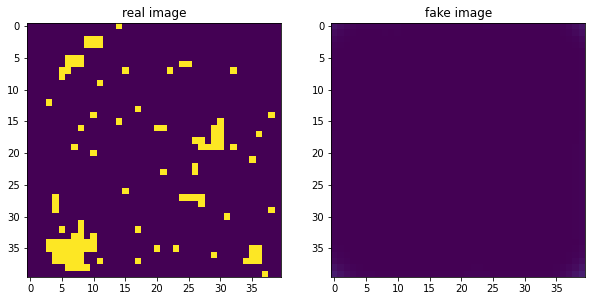

real average magnetization: 0.8852857142857142, fake average magnetization:0.9979024614824448
real average energy: -0.5904762, fake average energy:-1553.5463
Beginning epoch  12


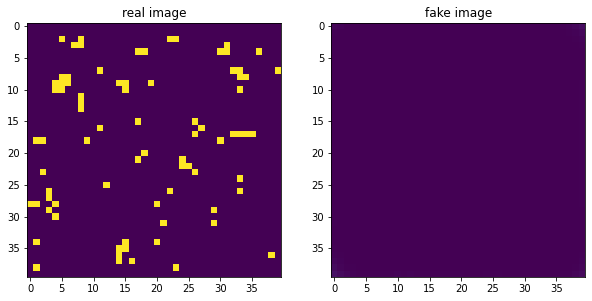

real average magnetization: 0.8869285714285714, fake average magnetization:0.9987723855226068
real average energy: -0.24761905, fake average energy:-1556.2902
Beginning epoch  13


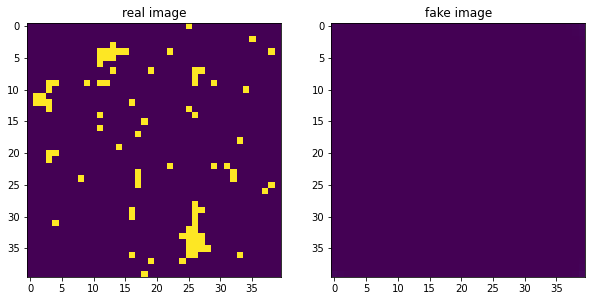

real average magnetization: 0.8889642857142858, fake average magnetization:0.9991262935858686
real average energy: -0.13333334, fake average energy:-1557.3816
Beginning epoch  14


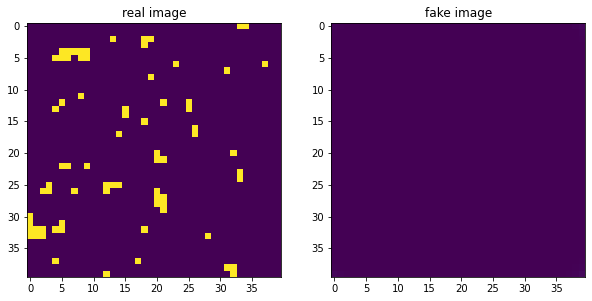

real average magnetization: 0.8887619047619048, fake average magnetization:0.9993460368066736
real average energy: -1.1619048, fake average energy:-1558.0264
Beginning epoch  15


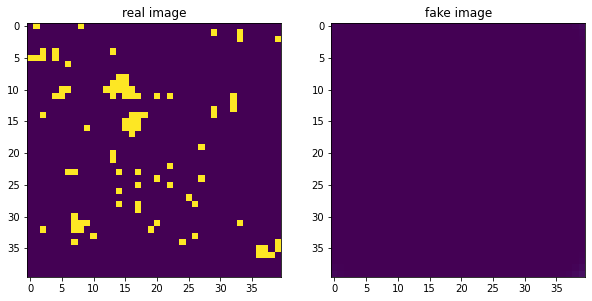

real average magnetization: 0.8850833333333333, fake average magnetization:0.9995217018463882
real average energy: -1.2, fake average energy:-1558.6011
Beginning epoch  16


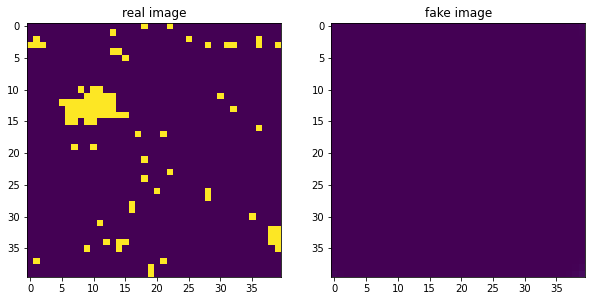

real average magnetization: 0.8849761904761905, fake average magnetization:0.999657966018567
real average energy: 0.1904762, fake average energy:-1559.0105
Beginning epoch  17


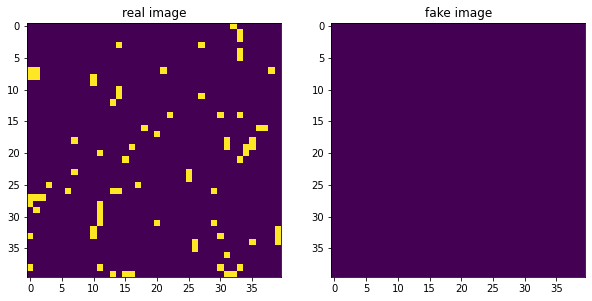

real average magnetization: 0.888547619047619, fake average magnetization:0.999732121453344
real average energy: 0.95238096, fake average energy:-1559.2323
Beginning epoch  18


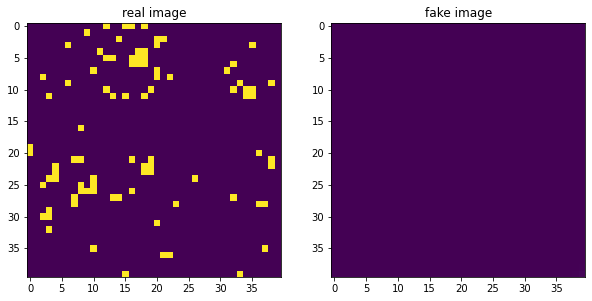

real average magnetization: 0.8908571428571429, fake average magnetization:0.999801870391675
real average energy: 0.53333336, fake average energy:-1559.4364
Beginning epoch  19


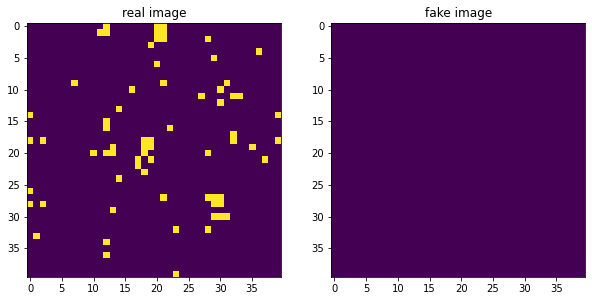

real average magnetization: 0.8902976190476191, fake average magnetization:0.999837439579278
real average energy: -0.24761905, fake average energy:-1559.5419
Beginning epoch  20


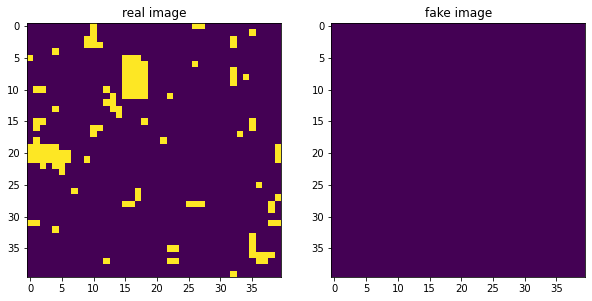

real average magnetization: 0.8838690476190476, fake average magnetization:0.9998825029052386
real average energy: 0.6857143, fake average energy:-1559.6725


In [18]:
# fit the GAN
gan.fit_data_custom(20)